# Help dr. Vasilescu

Using the modelling and control manual provided by ESA, help dr. Vasilescu to implement the controller in python, and fly the drone above her base. Maybe she will discover something she was not prepared for.

In [10]:
import math as m 
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from odeintw import *
from math import pi
from math import *
from scipy.signal import place_poles
from lab_functions import *

# parameters
m, g, l = 0.4, 9.8, 0.1778
Ix, Iy, Iz = 0.002, 0.0016, 0.0035
b, d = 192.32*10**(-7), 1*10**(-7)
c = 1.9712

def model(x,t,u):
    u = u.reshape(4,1)
    x = x.reshape(12,1)
    
    px     = x[0]
    py     = x[1]
    pz     = x[2]
    phi    = x[3]
    theta  = x[4]
    psi    = x[5]
    dx     = x[6]
    dy     = x[7]
    dz     = x[8]
    dphi   = x[9]
    dtheta = x[10]
    dpsi   = x[11]
    
    J = np.array([[Ix,              0,                                    -Ix*sin(theta)],
                 [0,               Iy*(cos(phi))**2+Iz*(sin(phi))**2,    (Iy-Iz)*cos(phi)*sin(phi)*cos(theta)],
                 [-Ix*sin(theta),  (Iy-Iz)*cos(phi)*sin(phi)*cos(theta),  Ix*(sin(theta))**2+Iy*(sin(phi))**2*(cos(theta))**2+Iz*(cos(phi))**2*(cos(theta))**2]])
    
    c11 = 0
    c12 = (Iy-Iz)*(dtheta*cos(phi)*sin(phi)+dpsi*(sin(phi))**2*cos(theta))+(Iz-Iy)*dpsi*(cos(phi))**2*cos(theta)-Ix*dpsi*cos(theta)
    c13 = (Iz-Iy)*dpsi*(cos(theta))**2*sin(phi)*cos(phi)
    c21 = (Iz-Iy)*(dtheta*sin(phi)*cos(phi)+dpsi*(sin(phi))**2*cos(theta))+(Iy-Iz)*dpsi*(cos(phi))**2*cos(theta)+Ix*dpsi*cos(theta)
    c22 = (Iz-Iy)*dphi*cos(phi)*sin(phi)
    c23 = -Ix*dpsi*sin(theta)*cos(theta)+Iy*dpsi*(sin(phi))**2*sin(theta)*cos(theta)+Iz*dpsi*(cos(phi))**2*sin(theta)*cos(theta)
    c31 = (Iy-Iz)*dpsi*(cos(theta))**2*sin(phi)*cos(phi)-Ix*dtheta*cos(theta)
    c32 = (Iz-Iy)*(dtheta*cos(phi)*sin(phi)*sin(theta)+dphi*(sin(phi))**2*cos(theta))+(Iy-Iz)*dphi*(cos(phi))**2*cos(theta)+Ix*dpsi*sin(theta)*cos(theta)-Iy*dpsi*(sin(phi))**2*sin(theta)*cos(theta)-Iz*dpsi*(cos(phi))**2*sin(theta)*cos(theta)
    c33 = (Iy-Iz)*dphi*(cos(theta))**2*sin(phi)*cos(phi)-Iy*dtheta*(sin(phi))**2*sin(theta)*cos(theta)-Iz*dtheta*(cos(phi))**2*sin(theta)*cos(theta)+Ix*dtheta*sin(theta)*cos(theta)
 
    if c12.shape == (1,): c12 = c12[0]
    if c13.shape == (1,): c13 = c13[0]
    if c21.shape == (1,): c21 = c21[0]
    if c22.shape == (1,): c22 = c22[0]
    if c23.shape == (1,): c23 = c23[0]
    if c31.shape == (1,): c31 = c31[0]
    if c32.shape == (1,): c32 = c32[0]
    if c33.shape == (1,): c33 = c33[0]

    C = np.array([[c11, c12, c13], [c21, c22, c23], [c31, c32, c33]])

    Jinv = np.linalg.inv(J)
   
    Ucoll  = u[0] + m*g
    Uphi   = u[1]
    Utheta = u[2]
    Upsi   = u[3]
            
    ddx  = theta*g 
    ddy  = -phi*g 
    ddz  = (Ucoll-m*g)/m 
    
    ddphi   = Uphi/Ix
    ddtheta = Utheta/Iy
    ddpsi   = Upsi/Iz

    xddot = np.array([dx,dy,dz,dphi,dtheta,dpsi,ddx,ddy,ddz,ddphi,ddtheta,ddpsi])

    return xddot

# time interval/sampling time
dt = 0.01

# final time
tf = 20

# nr of samples
n = int(np.round(tf/dt))

# Desired time samples for the solution.
t = np.arange(0, tf, dt)

radius = 0.2
freq = 1
height = 0.3

# Trajectory should be a circle on the XY plane
rx = radius * np.cos(t * freq)
ry = radius * np.sin(t * freq)
rz = 0.3*np.ones((n,1))

# initial conditions for the states (P and V)
px     = 0.0
py     = 0.0
pz     = 0.0
theta  = 0.0
phi    = 0.0
psi    = 0.0
dx     = 0.0
dy     = 0.0
dz     = 0.0
dphi   = 0.0
dtheta = 0.0
dpsi   = 0.0

x0 = np.array([[px], [py], [pz], [phi], [theta], [psi], [dx], [dy], [dz], [dphi], [dtheta], [dpsi]])

plotx     = np.zeros(n-1)
ploty     = np.zeros(n-1)
plotz     = np.zeros(n-1)
plotphi   = np.zeros(n-1)
plottheta = np.zeros(n-1)
plotpsi   = np.zeros(n-1)

u0 = np.zeros((4,n))

K = np.array([[24.7267,  0.0001, 22.1294, -0.0002, 54.2482, -0.0000, 22.3994,  0.0001, 10.8415, -0.0000,  2.0236, -0.0000],
              [-0.0000, -0.3909, -0.0000,  1.2201, -0.0000,  0.0001, -0.0000, -0.4084, -0.0000,  0.0914, -0.0000,  0.0000],
              [0.3998,   0.0000,  0.0000, -0.0000,  1.0992, -0.0000,  0.3919,  0.0000,  0.0000, -0.0000,  0.0776, -0.0000],
              [0.0000,  -0.1374,  0.0000,  0.0665,  0.0000,  0.1457,  0.0000, -0.0783,  0.0000,  0.0016,  0.0000,  0.0773]])

# integrator parameters
px_prev    = px
py_prev    = py
pz_prev    = pz
phi_prev   = phi
theta_prev = theta
psi_prev   = psi

xerror = 0
yerror = 0
zerror = 0

# Integrator gains, try values in range [-1,1], tune based on the graphs and intuition
kix = 0.15
kiy = -0.15
kiz =  5
# calculate gain
Ki = np.diag([kiz, kiy, kix, 0])

txerror = 0
tyerror = 0
tzerror = 0

integral = np.zeros((1,4))
u = np.zeros((4,n))
# solve ODE for each step
for i in range(1,n):
    printProgressBar((i+1)/n, prefix="Progress:", suffix="complete", length=60)


    
    # calculate reference
    ref = np.array([rz[i][0], ry[i], rx[i], 0])
    
    # span for next time step
    tspan = [t[i-1],t[i]]

    
    # state feedback
    # ro = u, v, w
    # 
    # x = zeta, niu, ro, pi
    state_feedback = -np.dot(K, x0)
    
    # state feedback & follow (equations 32 and 33)   
    state = np.array([pz, py, px, 0])
    error = ref - state
    
    integral += error * (tspan[1] - tspan[0]) 
    
    u[:,i] = (state_feedback + Ki.dot(integral.T)).reshape(4,)
    
    # solve for next step
    x = odeintw(model,x0,tspan,args=(u[:,i],))
    
    # store solution for plotting
    px    = x[1][0,0]
    py    = x[1][1,0]
    pz    = x[1][2,0]
    phi   = x[1][3,0]
    theta = x[1][4,0]
    psi   = x[1][5,0]
    
    dx     = (px - px_prev)/dt
    dy     = (py - py_prev)/dt
    dz     = (pz - pz_prev)/dt
    dphi   = (phi - phi_prev)/dt
    dtheta = (theta - theta_prev)/dt
    dpsi   = (psi - psi_prev)/dt

    # next initial condition 
    x0 = np.array([px, py, pz, phi, theta, psi, dx, dy, dz, dphi, dtheta, dpsi]).reshape(12,1)

    px_prev    = px
    py_prev    = py
    pz_prev    = pz
    phi_prev   = phi
    theta_prev = theta
    psi_prev   = psi
    
    plotx[i-1] = px
    ploty[i-1] = py
    plotz[i-1] = pz
    plotphi[i-1] = phi
    plottheta[i-1] = theta
    plotpsi[i-1] = psi

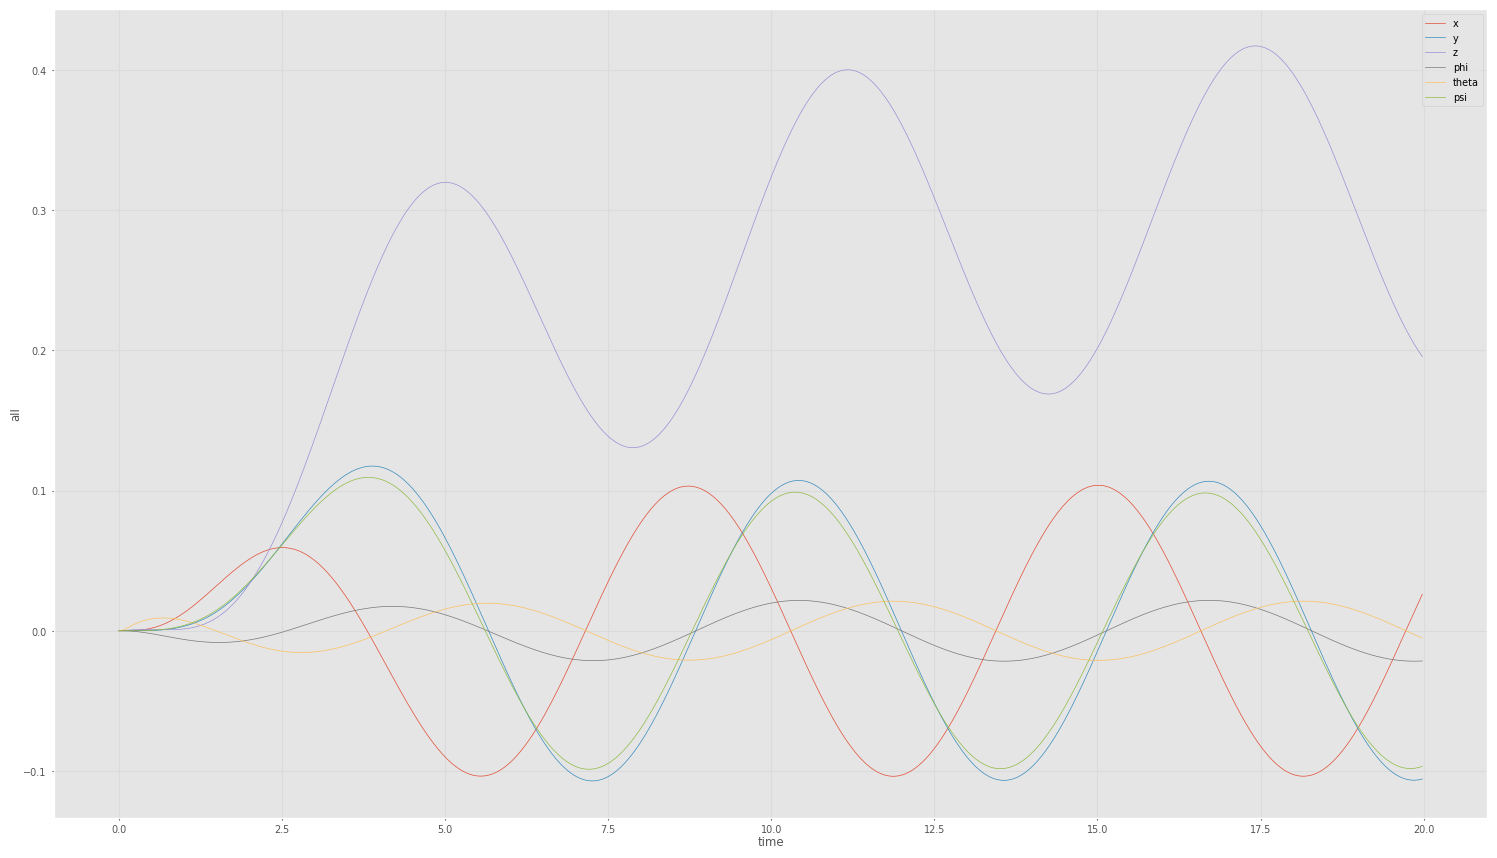

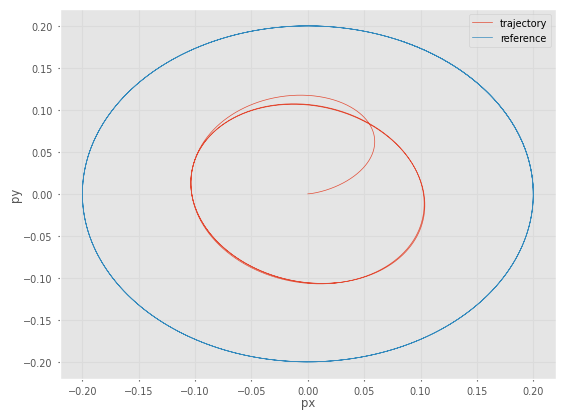

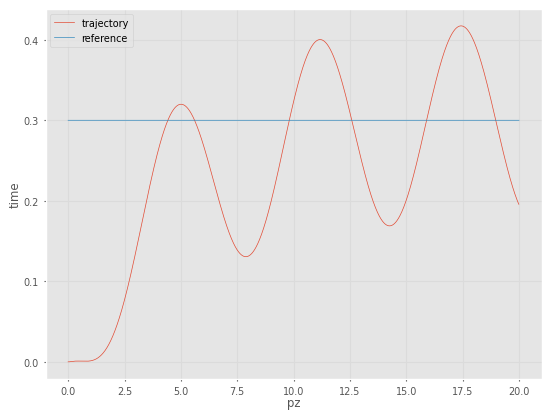

In [11]:
# pose of the vechicle P = [xi, eta] 
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.plot(t[:-1], plotx,  label='x')
plt.plot(t[:-1], ploty,  label='y')
plt.plot(t[:-1], plotz,  label='z')
plt.plot(t[:-1], plotphi,  label='phi')
plt.plot(t[:-1], plottheta,  label='theta')
plt.plot(t[:-1], plotpsi, label='psi')

plt.legend(loc='best')
plt.ylabel('all')
plt.xlabel('time')
plt.grid(True)

plt.show()
  
# x y plane motion
fig = plt.figure()

plt.plot(plotx, ploty,  label='trajectory')
plt.plot(rx, ry,  label='reference')

plt.legend(loc='best')
plt.ylabel('py')
plt.xlabel('px')
plt.grid(True)

plt.show()

# z motion
fig = plt.figure()

plt.plot(t[:-1], plotz,  label='trajectory')
plt.plot(t, rz,  label='reference')

plt.legend(loc='best')
plt.ylabel('time')
plt.xlabel('pz')
plt.grid(True)

plt.show()